In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, TorsionFingerprints, rdMolTransforms
from rdkit.Geometry.rdGeometry import Point3D

import py3Dmol

from typing import Optional, List, Tuple
import numpy as np
import numpy.typing as npt

In [2]:
def remove_duplicate_tas(tas_list):
    """
    Remove duplicate torsion angles from a list of torsion angle tuples.

    Args
    ----
    tas_list : list of tuples
        A list of torsion angle tuples, each containing four values:
        (atom1, atom2, atom3, atom4).

    Returns
    -------
    list of tuples: A list of unique torsion angle tuples, where duplicate angles have been removed.
    """
    tas = np.array(tas_list)
    clean_tas = []
    considered = []
    for row in tas:
        begin = row[1]
        end = row[2]
        if not (begin, end) in considered and not (end, begin) in considered:
            if begin > end:
                begin, end = end, begin
            duplicates = tas[np.logical_and(tas[:, 1] == begin, tas[:, 2] == end)]
            duplicates_reversed = tas[
                np.logical_and(tas[:, 2] == begin, tas[:, 1] == end)
            ]
            duplicates_reversed = np.flip(duplicates_reversed, axis=1)
            duplicates = np.concatenate([duplicates, duplicates_reversed], axis=0)
            assert duplicates.shape[-1] == 4
            duplicates = duplicates[
                np.where(duplicates[:, 0] == duplicates[:, 0].min())[0]
            ]
            clean_tas.append(duplicates[np.argmin(duplicates[:, 3])].tolist())
            considered.append((begin, end))
    return clean_tas

def get_rotatable_ta_list(mol):
    """
    Find unique rotatable torsion angles of a molecule. Torsion angle is given by a tuple of adjacent atoms'
    indices (atom1, atom2, atom3, atom4), where:
    - atom2 < atom3,
    - atom1 and atom4 are minimal among neighbours of atom2 and atom3 correspondingly.

    Torsion angle is considered rotatable if:
    - the bond (atom2, atom3) is a single bond,
    - none of atom2 and atom3 are adjacent to a triple bond (as the bonds near the triple bonds must be fixed),
    - atom2 and atom3 are not in the same ring.

    Args
    ----
    mol : RDKit Mol object
        A molecule for which torsion angles need to be detected.

    Returns
    -------
    list of tuples: A list of unique torsion angle tuples corresponding to rotatable bonds in the molecule.
    """
    torsion_pattern = "[*]~[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]~[*]"
    substructures = Chem.MolFromSmarts(torsion_pattern)
    torsion_angles = remove_duplicate_tas(list(mol.GetSubstructMatches(substructures)))
    return torsion_angles

def find_rotor_from_smiles(smiles):
    """
    Find unique rotatable torsion angles of a molecule. Torsion angle is given by a tuple of adjacent atoms'
    indices (atom1, atom2, atom3, atom4), where:
    - atom2 < atom3,
    - atom1 and atom4 are minimal among neighbours of atom2 and atom3 correspondingly.

    Torsion angle is considered rotatable if:
    - the bond (atom2, atom3) is a single bond,
    - none of atom2 and atom3 are adjacent to a triple bond (as the bonds near the triple bonds must be fixed),
    - atom2 and atom3 are not in the same ring.

    Parameters:
    smiles : str
        The SMILES string representing a molecule.

    Returns:
    list of tuples: A list of unique torsion angle tuples corresponding to rotatable bonds in the molecule.
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    return get_rotatable_ta_list(mol)

def _get_torsion_angles(
    smiles: str, indices: Optional[List[int]] = None
) -> List[Tuple[int]]:
    torsion_angles = find_rotor_from_smiles(smiles)
    if indices is not None:
        torsion_angles = [torsion_angles[i] for i in indices]
    return torsion_angles

def _get_positions(smiles: str) -> npt.NDArray:
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=0)
    return mol.GetConformer().GetPositions()

def get_torsion_angles_values(conf, torsion_angles_atoms_list):
    return [
        np.float32(rdMolTransforms.GetDihedralRad(conf, *ta))
        for ta in torsion_angles_atoms_list
    ]

def get_torsion_angles_atoms_list(mol):
    return [x[0][0] for x in TorsionFingerprints.CalculateTorsionLists(mol)[0]]


def get_all_torsion_angles(mol, conf):
    ta_atoms = get_torsion_angles_atoms_list(mol)
    ta_values = get_torsion_angles_values(conf, ta_atoms)
    return {k: v for k, v in zip(ta_atoms, ta_values)}

def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    #mol = Chem.AddHs(mol)
    #AllChem.EmbedMolecule(mol)
   # AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer



In [3]:
smiles = 'CCCCCC(=O)OC'

In [4]:
torsion_angles = _get_torsion_angles(smiles)
torsion_angles

[[0, 1, 2, 3],
 [1, 2, 3, 4],
 [9, 0, 1, 2],
 [2, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 7, 8],
 [5, 7, 8, 20]]

In [5]:
class RDKitConformer:
    def __init__(self, atom_positions, smiles):
        """
        :param atom_positions: numpy.ndarray of shape [num_atoms, 3] of dtype float64
        """
        self.smiles = smiles
        self.rdk_mol = self.get_mol_from_smiles(smiles)
        self.rdk_conf = self.embed_mol_and_get_conformer(self.rdk_mol)

        self.set_atom_positions(atom_positions)
        self.freely_rotatable_tas = get_rotatable_ta_list(self.rdk_mol)

    def __deepcopy__(self, memo):
        atom_positions = self.get_atom_positions()
        cls = self.__class__
        new_obj = cls.__new__(
            cls, atom_positions, self.smiles, self.freely_rotatable_tas
        )
        return new_obj

    def get_mol_from_smiles(self, smiles):
        """Create RDKit molecule from SMILES string
        :param smiles: python string
        :returns: rdkit.Chem.rdchem.Mol object"""
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        return mol

    def embed_mol_and_get_conformer(self, mol, extra_opt=False):
        """Embed RDkit mol with a conformer and return the RDKit conformer object
        (which is synchronized with the RDKit molecule object)
        :param mol: rdkit.Chem.rdchem.Mol object defining the molecule
        :param extre_opt: bool, if True, an additional optimisation of the conformer will be performed
        """
        AllChem.EmbedMolecule(mol)
        if extra_opt:
            AllChem.MMFFOptimizeMolecule(mol, confId=0, maxIters=1000)
        return mol.GetConformer()

    def set_atom_positions(self, atom_positions):
        """Set atom positions of the self.rdk_conf to the input atom_positions values
        :param atom_positions: 2d numpy array of shape [num atoms, 3] with new atom positions
        """
        for idx, pos in enumerate(atom_positions):
            self.rdk_conf.SetAtomPosition(idx, Point3D(*pos))

    def get_atom_positions(self):
        """
        :returns: numpy array of atom positions of shape [num_atoms, 3]
        """
        return self.rdk_conf.GetPositions()

    def get_atomic_numbers(self):
        """Get atomic numbers of the atoms as 1d numpy array
        :returns: numpy array of atomic numbers of shape [num_atoms,]"""
        atomic_numbers = [atom.GetAtomicNum() for atom in self.rdk_mol.GetAtoms()]
        return np.array(atomic_numbers)

    def get_n_atoms(self):
        return self.rdk_mol.GetNumAtoms()

    def set_torsion_angle(self, torsion_angle, value):
        rdMolTransforms.SetDihedralRad(self.rdk_conf, *torsion_angle, float(value))

    def get_all_torsion_angles(self):
        """
        :returns: a dict of all tostion angles in the molecule with their values
        """
        return get_all_torsion_angles(self.rdk_mol, self.rdk_conf)

    def get_freely_rotatable_tas_values(self):
        """
        :returns: a list of values of self.freely_rotatable_tas
        """
        return get_torsion_angles_values(self.rdk_conf, self.freely_rotatable_tas)


    def randomize_freely_rotatable_tas(self):
        """
        Uniformly randomize torsion angles defined by self.freely_rotatable_tas
        """
        for torsion_angle in self.freely_rotatable_tas:
            increment = np.random.uniform(0, 2 * np.pi)
            self.increment_torsion_angle(torsion_angle, increment)

    def increment_torsion_angle(self, torsion_angle, increment):
        """
        :param torsion_angle: tuple of 4 integers defining the torsion angle
        :param increment: a float value of the increment of the angle (in radians)
        """
        initial_value = rdMolTransforms.GetDihedralRad(self.rdk_conf, *torsion_angle)
        self.set_torsion_angle(torsion_angle, initial_value + increment)

In [6]:
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, randomSeed=0)
conf = mol.GetConformer()
test_pos = conf.GetPositions()
initial_tas = get_all_torsion_angles(mol, conf)
ad_atom_types = ("H", "C", "N", "O", "F", "S", "Cl")

conf = RDKitConformer(
    test_pos, smiles, ad_free_tas
)
atom_types = conf.get_atomic_numbers()


NameError: name 'ad_free_tas' is not defined

In [ ]:
conf.randomize_freely_rotatable_tas()
conf_tas = conf.get_all_torsion_angles()


In [ ]:
from tabulate import tabulate
# for k, v in conf_tas.items():
#     if k in conf.freely_rotatable_tas:
#         assert not np.isclose(v, initial_tas[k])
#     else:
#         assert np.isclose(v, initial_tas[k])

data = [[k, v1, v2] for (k, v1), v2 in zip(initial_tas.items(), conf_tas.values())]
print(
    tabulate(data, headers=["torsion angle", "initial value", "randomized value"])
)

torsion angle      initial value    randomized value
---------------  ---------------  ------------------
(0, 1, 2, 3)            1.04739           -2.21178
(1, 2, 3, 4)           -3.14088            2.3524
(2, 3, 4, 5)            1.06295            1.60654
(3, 4, 5, 6)            0.029731          -0.0198989
(4, 5, 7, 8)            3.14118           -2.14113


In [ ]:
new_pos = conf.get_atom_positions()

In [ ]:
from matplotlib import pyplot as plt

def plot_pos(pos, atom_types):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    edge_index_artificial = []
    for i, p1 in enumerate(pos):
        for j, p2 in enumerate(pos):
            if i == j:
                continue
            if np.linalg.norm(p1 - p2, ord=2) < 1.75:
                edge_index_artificial.append([i, j])
    edge_index_artificial = np.array(edge_index_artificial).T

    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=atom_types, s=100)
    for edge in edge_index_artificial:
        ax.plot(pos[edge, 0], pos[edge, 1], pos[edge, 2], color='black')
    plt.show()


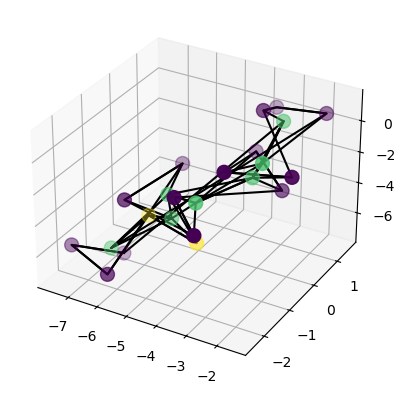

In [ ]:
plot_pos(new_pos, atom_types)

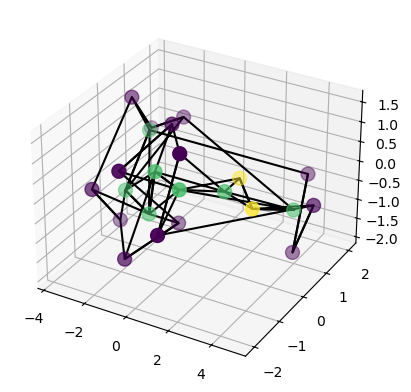

In [ ]:
plot_pos(test_pos, atom_types)

# Plan


What we want is to:
1. Create a molecule. 
2. Extract all torsion angles
3. Parametrize the GFN with a von Mises distribution
4. Sample new angles
5. Apply them to the molecule graph
6. Reward the new conformation
7. Backprop

Is step 5. differentiable?


In [56]:
from rdkit.Chem import TorsionFingerprints


mol = Chem.MolFromSmiles(' c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl')
mol = Chem.AddHs(mol)

ring, nonring = TorsionFingerprints.CalculateTorsionLists(mol, )

def collect_4tuples(output):
    result = []
    for item in output:
        tuples_list, _ = item
        result.extend(tuples_list)
    return result

x = collect_4tuples(ring+nonring)
np.array(x)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [53]:
l = []
for x in ring:
    for y in x:
        if type(y) == list:
            l.append(y[0])
for x in nonring:
    for y in x:
        if type(y) == list:
            l.append(y)
l

[(4, 5, 6, 7),
 [(0, 5, 4, 3),
  (5, 4, 3, 2),
  (4, 3, 2, 1),
  (3, 2, 1, 0),
  (2, 1, 0, 5),
  (1, 0, 5, 4)],
 [(7, 8, 9, 10),
  (8, 9, 10, 11),
  (9, 10, 11, 6),
  (10, 11, 6, 7),
  (11, 6, 7, 8),
  (6, 7, 8, 9)]]